#### Tweak 3.1 — Stacked Conv Blocks + Dropout Regularization

#### 1.1 Environment Check

In [151]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
import time
import copy

In [152]:
# reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# device selection: CUDA > MPS > CPU
if torch.cuda.is_available():
    device = torch.device('cuda')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(f'PyTorch version : {torch.__version__}')
print(f'Device          : {device}')
if device.type == 'cuda':
    print(f'GPU             : {torch.cuda.get_device_name(0)}')
    print(f'VRAM            : {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB')

PyTorch version : 2.9.0+cu128
Device          : cuda
GPU             : Tesla T4
VRAM            : 15.6 GB


#### 1.2 The Subset

In [153]:
def get_cifar10_subsets(n_train=5000, n_test=1000, batch_size=64, num_workers=2):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2470, 0.2435, 0.2616))
    ])

    full_train = torchvision.datasets.CIFAR10(
        root='../data', train=True, download=True, transform=transform)
    full_test = torchvision.datasets.CIFAR10(
        root='../data', train=False, download=True, transform=transform)

    train_subset = Subset(full_train, range(n_train))
    test_subset  = Subset(full_test,  range(n_test))

    train_loader = DataLoader(train_subset, batch_size=batch_size,
                              shuffle=True, num_workers=num_workers)
    val_loader   = DataLoader(test_subset,  batch_size=batch_size,
                              shuffle=False, num_workers=num_workers)

    return train_loader, val_loader, full_train.classes

In [154]:
train_loader, val_loader, classes = get_cifar10_subsets()

print(f'Training samples   : {len(train_loader.dataset)}')
print(f'Validation samples : {len(val_loader.dataset)}')
print(f'Classes            : {classes}')
print(f'Batch size         : {train_loader.batch_size}')

# quick sanity peek
imgs, labels = next(iter(train_loader))
print(f'Batch shape        : {imgs.shape}')  # [64, 3, 32, 32]

Training samples   : 5000
Validation samples : 1000
Classes            : ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Batch size         : 64
Batch shape        : torch.Size([64, 3, 32, 32])


### 1.3 The Evaluation Suite

In [155]:
def count_parameters(model):
    """Return total number of trainable parameters."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [156]:
@torch.no_grad()
def evaluate(model, dataloader, criterion, device):
    """Compute average loss and accuracy on a dataloader."""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    avg_loss = running_loss / total
    accuracy = 100.0 * correct / total
    return avg_loss, accuracy

In [157]:
def train_model(model, train_loader, val_loader, criterion, optimizer,
                device, epochs=15):
    """
    Standard training loop. Returns history dict with per-epoch metrics.
    """
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [],   'val_acc': []
    }
    best_val_acc = 0.0
    best_weights = None

    for epoch in range(1, epochs + 1):
        # --- train ---
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / total
        train_acc  = 100.0 * correct / total

        # --- validate ---
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        # record
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # checkpoint best
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_weights = copy.deepcopy(model.state_dict())

        print(f'Epoch {epoch:3d}/{epochs}  |  '
              f'Train Loss: {train_loss:.4f}  Acc: {train_acc:.2f}%  |  '
              f'Val Loss: {val_loss:.4f}  Acc: {val_acc:.2f}%')

    # restore best weights
    if best_weights:
        model.load_state_dict(best_weights)
    print(f'\nBest validation accuracy: {best_val_acc:.2f}%')
    return history

In [158]:
def plot_history(history, title='Training History'):
    """Plot loss and accuracy curves side by side."""
    epochs = range(1, len(history['train_loss']) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # --- loss ---
    ax1.plot(epochs, history['train_loss'], 'o-', label='Train Loss')
    ax1.plot(epochs, history['val_loss'],   's-', label='Val Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title(f'{title} — Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # --- accuracy ---
    ax2.plot(epochs, history['train_acc'], 'o-', label='Train Acc')
    ax2.plot(epochs, history['val_acc'],   's-', label='Val Acc')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title(f'{title} — Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

#### 2.1 Build Model 3.1 — Stacked Conv Blocks + Dropout

In [159]:
class DeepCNN_Stacked_Dropout(nn.Module):
    """
    Model 2.1: Stacked Conv Blocks (from 1.3) + Dropout Regularization (from 02).
    
    Architecture:
        Block 1: (Conv2d(3->32, 3x3) -> BatchNorm -> ReLU) x 2 -> MaxPool(2) -> Dropout2d(0.1)
        Block 2: (Conv2d(32->64, 3x3) -> BatchNorm -> ReLU) x 2 -> MaxPool(2) -> Dropout2d(0.1)
        Block 3: (Conv2d(64->128, 3x3) -> BatchNorm -> ReLU) x 2 -> MaxPool(2) -> Dropout2d(0.1)
        AdaptiveAvgPool2d(1)  (GAP)
        Flatten -> Dropout(0.5) -> FC(128 -> 10)
    
    Key differences from Model 1.3:
    - Dropout2d(p=0.1) after each MaxPool for spatial regularization
    - Dropout(p=0.5) before the final classifier to reduce overfitting
    """

    def __init__(self):
        super().__init__()
        
        # Block 1: 3 -> 32 channels
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),    # 32x32 -> 32x32
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),   # 32x32 -> 32x32
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),                                # 32x32 -> 16x16
            nn.Dropout2d(0.1)
        )
        
        # Block 2: 32 -> 64 channels
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),   # 16x16 -> 16x16
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),   # 16x16 -> 16x16
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),                                # 16x16 -> 8x8
            nn.Dropout2d(0.1)
        )
        
        # Block 3: 64 -> 128 channels
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # 8x8 -> 8x8
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1), # 8x8 -> 8x8
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),                                # 8x8 -> 4x4
            nn.Dropout2d(0.1)
        )
        
        # Global Average Pooling + Classifier
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),   # (batch, 128, 4, 4) -> (batch, 128, 1, 1)
            nn.Flatten(),              # (batch, 128, 1, 1) -> (batch, 128)
            nn.Dropout(0.5),           # Dropout before FC for regularization
            nn.Linear(128, 10)         # 128*10 + 10 = 1,290 params
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.classifier(x)
        return x

In [160]:
model = DeepCNN_Stacked_Dropout().to(device)
print(model)
print(f'\nTrainable parameters: {count_parameters(model):,}')

DeepCNN_Stacked_Dropout(
  (block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout2d(p=0.1, inplace=False)
  )
  (block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fa

### 2.2 Train for 15 Epochs

In [161]:
EPOCHS = 15 # complete pass through your entire training dataset
LR = 1e-3   # Learning Rate

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

print(f'Optimizer : Adam (lr={LR})')
print(f'Loss fn   : CrossEntropyLoss')
print(f'Epochs    : {EPOCHS}')
print(f'Device    : {device}')
print('-' * 65)

start = time.time()
history = train_model(model, train_loader, val_loader, criterion,
                      optimizer, device, epochs=EPOCHS)
elapsed = time.time() - start
print(f'\nTraining time: {elapsed:.1f}s')

Optimizer : Adam (lr=0.001)
Loss fn   : CrossEntropyLoss
Epochs    : 15
Device    : cuda
-----------------------------------------------------------------
Epoch   1/15  |  Train Loss: 1.9932  Acc: 25.00%  |  Val Loss: 1.7426  Acc: 31.60%
Epoch   2/15  |  Train Loss: 1.7578  Acc: 32.88%  |  Val Loss: 1.7914  Acc: 31.80%
Epoch   3/15  |  Train Loss: 1.6524  Acc: 38.84%  |  Val Loss: 1.5041  Acc: 43.60%
Epoch   4/15  |  Train Loss: 1.5483  Acc: 42.34%  |  Val Loss: 1.3670  Acc: 48.70%
Epoch   5/15  |  Train Loss: 1.4547  Acc: 46.26%  |  Val Loss: 1.3561  Acc: 48.90%
Epoch   6/15  |  Train Loss: 1.3840  Acc: 49.22%  |  Val Loss: 1.3014  Acc: 52.10%
Epoch   7/15  |  Train Loss: 1.3329  Acc: 52.32%  |  Val Loss: 1.1979  Acc: 57.90%
Epoch   8/15  |  Train Loss: 1.2679  Acc: 54.12%  |  Val Loss: 1.2559  Acc: 55.50%
Epoch   9/15  |  Train Loss: 1.2182  Acc: 54.82%  |  Val Loss: 1.2159  Acc: 56.20%
Epoch  10/15  |  Train Loss: 1.2038  Acc: 56.88%  |  Val Loss: 1.1485  Acc: 59.70%
Epoch  11/15  |

#### 2.3 Visualize Training Curves

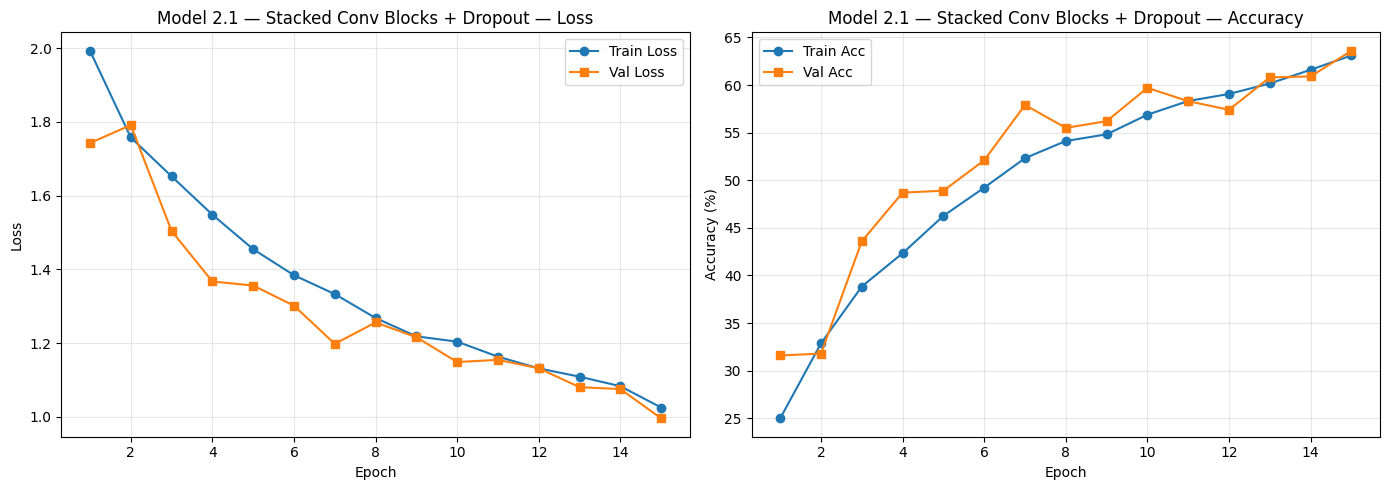

In [162]:
plot_history(history, title='Model 2.1 — Stacked Conv Blocks + Dropout')

### 2.4 Results Summary

In [164]:
final_train_acc = history['train_acc'][-1]
final_val_acc   = history['val_acc'][-1]
peak_val_acc    = max(history['val_acc'])
gap             = final_train_acc - final_val_acc

print('=' * 55)
print('   MODEL 3.1 — RESULTS SUMMARY (Stacked Blocks + Dropout)')
print('=' * 55)
print(f'  Parameters       : {count_parameters(model):,}')
print(f'  Final Train Acc  : {final_train_acc:.2f}%')
print(f'  Final Val Acc    : {final_val_acc:.2f}%')
print(f'  Peak Val Acc     : {peak_val_acc:.2f}%')
print(f'  Train-Val Gap    : {gap:+.2f}%')
print(f'  Final Train Loss : {history["train_loss"][-1]:.4f}')
print(f'  Final Val Loss   : {history["val_loss"][-1]:.4f}')
print(f'  Diagnosis      : High bias (underfitting).')
print('=' * 55)

   MODEL 3.1 — RESULTS SUMMARY (Stacked Blocks + Dropout)
  Parameters       : 289,194
  Final Train Acc  : 63.10%
  Final Val Acc    : 63.60%
  Peak Val Acc     : 63.60%
  Train-Val Gap    : -0.50%
  Final Train Loss : 1.0250
  Final Val Loss   : 0.9957
  Diagnosis      : High bias (underfitting).
